# Trabajo de las N - Reinas: Erik Cedro, Enmanuel de la Fuente, Adrián de Arcos, Rayan Chekour

# Código github: https://github.com/ajkooo/n_queens_proyecto.git

 # **00 JERARQUÍA Y ESTRUCTURA DEL PROYECTO**

Este proyecto está organizado en módulos (ficheros) para permitir la **comparación directa de rendimiento** entre los diferentes paradigmas / prototipos para resolver el problema de las N-Reinas. La arquitectura se divide en tres niveles de abstracción:

### 1. Nivel de Control: El Script Principal (`principal.py`)

El archivo **`principal`** actúa como la unidad central de comando desde la cual se ejecuta el programa. Se encarga de los siguientes elementos:

* **Interfaz de Usuario:** Solicita el parámetro $N$ (tamaño del tablero) y el modo de operación.
* **Selección de Estrategia:** Decide qué algoritmo ejecutar basándose en la entrada del usuario (`b` para Backtracking, `m` para Min-Conflicts o `c` para comparar ambos).
* **Puntos de referencia (benchmarking):** Mide con precisión el tiempo de ejecución (usando `time.perf_counter`) para contrastar la eficiencia de los métodos.

### 2. Nivel de Lógica: Algoritmos de Solución

El núcleo del proyecto contrasta dos enfoques opuestos, además de analizar un tercero descartado por ineficiencia en este entorno específico.

| Método | Paradigma / Enfoque | Estado en Código | Objetivo Clave |
| :--- | :--- | :--- | :--- |
| **Backtracking** | **Completo (Determinista)** | Implementado | Encontrar **todas** las soluciones exactas o verificar inexistencia. |
| **Min-Conflicts** | **Heurístico (Estocástico)** | Implementado | Encontrar **una** solución rápidamente en tableros masivos ($N > 100$). |
| **Bitwise (Bits)** | **Optimización de bajo nivel** | *Descartado* (Ver análisis abajo) | Intentar acelerar el backtracking usando operaciones lógicas de CPU. |

### 3. Nivel de Presentación: Visualización y Documentación

* **Librería `matplotlib`:** Se utiliza en `matplotlib1.py` y `estudiotiempo.py` para generar la representación visual del tablero con las reinas (`♛`) y trazar las gráficas logarítmicas de rendimiento (Tiempo vs N).
* **Archivo `README`:** Documentación esencial que describe dependencias, instrucciones de uso y la lógica detrás de la selección de algoritmos según el tamaño de $N$.

---

## **ANEXO TÉCNICO: ¿Por qué descartamos la Manipulación de Bits?**

Durante el desarrollo del proyecto, se evaluó el uso de **Bit Manipulation (Bitmasking)**. Esta técnica consiste en representar el tablero de ajedrez no como una matriz (array 2D) ni como una lista, sino como una secuencia de **bits (0s y 1s)** dentro de un número entero.

### ¿Cómo funciona?
En lugar de iterar sobre casillas, se utilizan operadores lógicos (`&`, `|`, `^`, `<<`, `>>`) para calcular posiciones seguras en un solo paso. Las restricciones se manejan mediante tres enteros:
1.  `cols`: Columnas ocupadas.
2.  `ld`: Diagonales izquierdas ocupadas.
3.  `rd`: Diagonales derechas ocupadas.

La operación clave para encontrar huecos libres es:
$$\text{disponible} = \sim(\text{cols} \mid \text{ld} \mid \text{rd})$$

### El problema con Python vs. C/C++
A pesar de ser algorítmicamente superior, se descartó en esta implementación en Python por razones de arquitectura del lenguaje:

1.  **Sobrecarga de Objetos (Overhead):**
    * En **C/C++**, un entero (`uint64_t`) es un espacio crudo en memoria. La operación `AND` es una única instrucción de CPU (1 ciclo de reloj).
    * En **Python**, todo es un objeto (`PyObject`). Un entero en Python es una estructura compleja que soporta precisión arbitraria. Realizar una operación de bits implica que el intérprete debe "desempaquetar" el objeto, realizar la operación y crear un nuevo objeto, lo que añade una latencia significativa.

2.  **Límite de Hardware vs Software:**
    * La manipulación de bits brilla cuando $N \le 64$ porque cabe en los registros nativos del procesador de 64 bits.
    * Python maneja enteros de tamaño infinito automáticamente, pero lo hace por software, no por hardware. Al superar los 64 bits, Python pierde la aceleración nativa de la CPU, volviéndose incluso más lento que el uso de listas convencionales para este propósito específico.

**Conclusión:** La manipulación de bits es ideal para **C, C++ o Rust**, pero en Python, la mejora de rendimiento es marginal comparada con la complejidad que añade al código, y nunca supera la escalabilidad del algoritmo **Min-Conflicts** para $N$ grandes. Otra justificación por la que se prescinde de este método es que C se compila a código máquina "nativo" generado por un archivo que se puede ejecutar directamente (.exe) mientras que Python lee el código instrucción por instrucción mientras se está ejecutando.

---

# ÍNDICE


* **01 ORIGEN Y DEFINICIÓN**
* **02 BACKTRACKING**
* **03 MIN-CONFLICTS**
* **04 REPRESENTACIÓN VISUAL (MATPLOTLIB)**
* **05 CÓDIGO PRINCIPAL**
* **06 APLICACIONES REALES**
* **07 VISUALIZACIÓN Y CONCLUSIONES**
* **08 WEBGRAFÍA**


# **01 ORIGEN Y DEFINICIÓN**

# Análisis del Problema de las $N$-Reinas

Nuestro proyecto analiza el problema de las **$N$-Reinas**, un desafío que, aunque nació en el ajedrez, es fundamental en la computación moderna.

Para comprender la magnitud de este proyecto, es necesario remontarnos a su origen. El problema de las $N$-Reinas nació como un rompecabezas lógico en el ámbito del ajedrez del siglo XIX:

* **1848:** Fue formulado inicialmente por el ajedrecista alemán **Max Bezzel** para el tablero estándar de $8 \times 8$.
* **1850:** Su verdadera relevancia matemática surgió cuando **Franz Nauck** generalizó el planteamiento para tableros de cualquier dimensión $N \times N$.



### El Objetivo
El objetivo fundamental es situar $N$ reinas en el tablero de tal manera que ninguna se encuentre bajo amenaza. Esto implica satisfacer tres restricciones espaciales simultáneas. Esta **"regla de oro"** de compone de tres condiciones:


1.  No deben compartir la misma **fila**.
2.  No deben compartir la misma **columna**.
3.  No deben compartir ninguna **diagonal**.


### Abstracción Computacional
Desde una perspectiva computacional, nuestra primera tarea fue la **abstracción del problema**. En lugar de procesar una matriz bidimensional completa —lo cual sería ineficiente en términos de memoria—, modelamos el tablero como un **vector unidimensional** de longitud $N$.

En este vector:

$\vec{v} = [c_0, c_1, \dots, c_{N-1}]$


1.  El **índice** del arreglo representa la **fila**.
2.  El **valor almacenado** representa la **columna** donde se ubica la reina.

De esta manera:

De esta forma, las restricciones de fila y columna se resuelven implícitamente, y el algoritmo se centra exclusivamente en validar la restricción matemática de las diagonales:

$$\left| c_i - c_j \right| \neq \left| i - j \right|$$

> **Nota:** Esta optimización es crucial para el rendimiento de los algoritmos que presentaremos, ya que reduce la complejidad espacial y simplifica las iteraciones.



# **02 BACKTRACKING CLÁSICO**


El backtracking es una técnica de programación basada en una busqueda sistemática a través de todos los caminos posibles.Para conseguir esto, por medio del backtracking se generan posibles soluciones candidatas que se van construyendo paso a paso.Si en algún momento alguna de estas posibles soluciones incumpliese las restricciones del problema(como que haya dos reinas en la misma fila,columna o diagonal),dicha solución se descarta y se vuelve hacia atrás para comprobar otro camino distinto.Así sucesivamente hasta que se hallan las soluciones que satisfagan las condiciones del problema.


## Explicación del código a partir de backtracking
Para simplificar el problema, el tablero(que es la variable que guarda las posiciones de las reinas en el tablero nxn) es una matriz nxn "camuflada" como lista la cual funciona de manera que cada índice de la lista corresponde a una fila del tablero y el valor albergado en cada posición, indica la columna donde se ha colocado la reina en esa fila.

Por otro lado,para la realización de este código se han usado 3 funciones cada una con una distinta funcionalidad.En primer lugar, la primera función es el cuerpo de nuestro código la cual nos permitirá implementar el backtracking posteriormente.Esta primera función es la que se va a encargar de verificar si el lugar donde se coloca la reina en cada posición acata las restricciones del problema(que no haya dos reinas en una misma fila,columna o diagonal).

1.La primera condición verifica que no estén en la misma columna.Para que dos reinas estén en la misma columna se tiene que cumplir que:
###                                           ∣Δcolumna∣=0


2.La segunda condición verifica que no estén en una misma diagonal.Para que dos reinas estén en la misma diagonal se tiene que cumplir que:
###                                          |Δfila| == |Δcolumna|


###### Nota:No hace falta verificar las filas ya que el código en si va fila por fila cpmprobando todas las columnas, entonces nunca coincidirán las filas.


In [ ]:
def es_valido(fila, col, reinas):
    """Verifica si es seguro colocar una reina en la posición (fila, col)."""
    #Creamos un bucle que recorra las filas de todo el tablero,por lo que no es necesario comprobar si están en la misma fila.
    #De esta manera, aparecen variables r y queens[r] que se refiere a las filas y columnas donde ya hay una reina.
    for r in range(fila):
         #Para comprobar si están en la misma columna
        if col == reinas[r]:
            return False
        #Para comprobar si estan en la misma diagonal(ponemos valor absoluto porque si ponemos la diagonal izquierda en uno sale 1 y otro -1)
        elif abs(col - reinas[r]) == abs(fila - r):
            return False
    #Se coloca la reina ya que es seguro
    return True


Para la realización de backtracking se definen dos funciones.Por un lado, una primera función que es la que establece el el tamaño n de tablero que necesitamos y el número de soluciones que queremos obtener.Dentro de esta, se define la variable "reinas" que es una lista temporal que se va modificando de manera que se sustituyen sus valores por otros numeros que equivalen a la columna donde esta la reina,todo esto hasta que se da con una solución (los índices representan las filas).Asímismo, cuando se da con una solución, se guarda dentro de la lista "solutions"(que va guardando todas las soluciones del problema).


Por otro lado, se define una segunda función(dentro de esta última) que recorre todas las columnas de cada fila para ver dónde se puede colocar una reina, utilizando la función "es_valido"(definida al principio del código). Si nos devuelve un True ,es decir, si la posición es válida , se coloca la reina en la columna de la fila dada y se llama a la funcion "colocar_reinas" de forma recursiva para avanzar a la siguiente fila. La recursión termina cuando se encuentra una solución completa(entonces dicha solución se guarda en la lista "soluciones") o cuando no se puede seguir avanzando,en ambos casos la función termina se retrocede(backtracking) con reinas[filas] = -1 para probar otras columnas y seguir buscando todas las posibles soluciones.Cabe recalcar que cuando no se puedes seguir avanzando, la función termina debido a que el bucle for acaba, de esta manera se vuelve hacia atrás con backtracking.De la misma manera funciona para cuando se encuentra una solución pero termina por el return que despues del comando soluciones.append. Por otro lado, cuando vuelve hacia atrás por donde se había quedado buscando antes, es como si la función anterior se hubiese quedado parada y cuando se vuelve hacia atrás se reanuda.

In [ ]:
def soluciones_reinas(n, limite_soluciones=1):

    reinas = [-1] * n
    soluciones = []

    def colocar_reinas(fila):
    #Encuentra hasta 'limite_soluciones' distintas para N reinas usando Backtracking.

        # Si ya tenemos suficientes soluciones, paramos la búsqueda para no saturar
        if len(soluciones) >= limite_soluciones:
            #Termina la función para seguir buscando por donde nos quedamos en la anterior fila
            return

        if fila == n:
            #Si las filas==n eso significa que el programa ya ha colocado todas las reinas posibles(porque ya no existen más filas )
            # por lo que ha encontrado una solución,entonces la imprimimos
            soluciones.append(list(reinas))
            #este return detiene la recursión ya que una solución ha sido encontrada
            return
        #Recorremos todas las columnas posibles
        for col in range(n):
            contador_iteraciones+=1
            #Utilizamos la primera función que nos indica si es seguro colocar una reina en esa posición
            if es_valido(fila, col, reinas):
                #Si es seguro entonces coloca una reina en la fila y columnas dadas
                reinas[fila] = col
                #Ahora coloca la reina para la siguiente fila, hasta o bien encontrar la solución
                #o darse cuente de que no se puede con las colocaciones que se tenían anteriormente
                colocar_reinas(fila + 1)
                # Backtracking: quitamos la reina para probar la siguiente columna
                #el queens[row] = -1  solo se ejecuta cuando no se puede seguir avanzando con las reinas que se tenía

                reinas[fila] = -1

#Empieza colocando la reina en la fila 0

    colocar_reinas(0)
    return soluciones
print(soluciones_reinas(n))

### Código entero y funcionabilidad

In [ ]:

#BACKTRACKING ENTERO

def es_valido(fila, col, reinas):

    for r in range(fila):
         #Para comprobar si están en la misma columna
        if col == reinas[r]:
            return False
        #Para comprobar si estan en la misma diagonal
        elif abs(col - reinas[r]) == abs(fila - r):
            return False
    #Se coloca la reina
    return True

def soluciones_reinas(n, limite_soluciones=1):

    reinas = [-1] * n
    soluciones = []

    def colocar_reinas(fila):
        # Si ya tenemos suficientes soluciones, paramos la búsqueda para no saturar
        if len(soluciones) >= limite_soluciones:
            return

        if fila== n:
           #Criterio de parada
            soluciones.append(list(reinas))
            return
        for col in range(n):
            if es_valido(fila, col, reinas):
                #Si es seguro entonces coloca una reina en la fila y columnas dadas
                reinas[fila] = col
                #Ahora coloca la reina para la siguiente fila, hasta o bien encontrar la solución
                #o darse cuente de que no se puede con las colocaciones que se tenían anteriormente
                colocar_reinas(fila+ 1)
                # Backtracking: quitamos la reina para probar la siguiente columna
                reinas[fila] = -1

#Empieza colocando la reina en la fila 0
    colocar_reinas(0)
    return soluciones
print(soluciones_reinas(n=8))

# Estudio de datos


### Contador de iteraciones


Para el correcto estudio de la eficiencia del algoritmo, hemos realizado una recogida de datos con el objetivo de analizar cómo opera el programa durante su ejecución. Este análisis resulta útil debido al elevado coste computacional que puede alcanzar el algoritmo a medida que aumenta el tamaño del tablero.


Por un lado, hemos utilizado un contador de iteraciones, el cual ha sido situado de manera que contabiliza el número de veces que el algoritmo recorre todas las columnas del tablero. Este contador nos permite medir de forma precisa cuántas comprobaciones realiza el programa al intentar colocar una reina en una posición válida.

In [ ]:
#--EJEMPLO CON BACKTRACKING--

def es_valido(fila, col, reinas):
    for r in range(fila):
        if col == reinas[r]:
            return False
        elif abs(col - reinas[r]) == abs(fila - r):
            return False
    return True

def soluciones_reinas(n, limite_soluciones=1):
    reinas = [-1] * n
    soluciones = []
    #Definimos un contador de iteraciones
    contador_iteraciones = 0

    def colocar_reinas(fila):
    ##Esto se usa para que la función colocar_reinas() pueda modificar la variable contador_iteraciones definida en soluciones_reinas().
        nonlocal contador_iteraciones

        if len(soluciones) >= limite_soluciones:
            return

        if fila == n:
            soluciones.append(list(reinas))
            return

        for col in range(n):
          #Sumamos 1 por cada columna que recorre
            contador_iteraciones += 1
            if es_valido(fila, col, reinas):
                reinas[fila] = col
                colocar_reinas(fila + 1)
                reinas[fila] = -1

    colocar_reinas(0)
    return soluciones, contador_iteraciones

soluciones, iteraciones = soluciones_reinas(n=8)
print(soluciones)
print(iteraciones)

Para continuar con un estudio real de la eficiencia de ambos métodos, hemos usado el módulo time para calcular cuanto tarda cada uno en ejecutarse.Para ello hay que usar un contador de inicio con el comando (time.perfcounter) que establece un contador desde el principio de la función en el momento que se inicializa y luego usamos otro al final de la misma manera que acaba en el momento que da todas las soluciones requeridas. Esto se hace de esta manera ya que este módulo no toma el inicio en el instante cero,sino que toma el inicio según el reloj interno que tiene el ordenador,se resta el tiempo final menos el inicial para que nos dé el tiempo que tarda en ejecutarse.

In [ ]:
#--EJEMPLO CON BACKTRACKING--

#Importamos la librería time

import time
def es_valido(fila, col, reinas):
    for r in range(fila):
        if col == reinas[r]:
            return False
        elif abs(col - reinas[r]) == abs(fila - r):
            return False
    return True

def soluciones_reinas(n, limite_soluciones=1):
    reinas = [-1] * n
    soluciones = []



    def colocar_reinas(fila):



        if len(soluciones) >= limite_soluciones:
            return

        if fila == n:
            soluciones.append(list(reinas))
            return

        for col in range(n):

            if es_valido(fila, col, reinas):
                reinas[fila] = col
                colocar_reinas(fila + 1)
                reinas[fila] = -1

    colocar_reinas(0)
    return soluciones
    #Contador de tiempo inicial
inicio = time.perf_counter()
soluciones = soluciones_reinas(n=8)
#Contador de tiempo  final
fin = time.perf_counter()
print(soluciones)
#Imprimimos el tiempo de ejecución
print("El tiempo de ejecución es", fin-inicio)


# **03 MIN-CONFLICTS**


El algoritmo Min-Conflicts **(Mínimos Conflictos)** es un método de búsqueda local heurística. A diferencia de los algoritmos tradicionales que intentan construir una solución paso a paso desde cero **(como el backtracking)**, este algoritmo empieza con una solución completa pero incorrecta y trata de **"repararla"** iterativamente.

## *Funcionamiento en el Problema de las N-Reinas*

En el contexto de las N-Reinas, el objetivo es colocar **N** reinas en un tablero de **dimension N** sin que ninguna se ataque entre sí:
#### *Inicialización:*
Se colocan las **N** reinas en el tablero de forma aleatoria (una por columna). En este punto, habrá muchos conflictos (ataques).
#### *Selección:*
Se elige aleatoriamente una reina que esté siendo atacada actualmente (una que tenga "conflictos").
#### *Movimiento (La Heurística):*
Se mueve esa reina a la casilla donde menos ataques reciba (mínimos conflictos).
#### *Repetición:*
Se repiten estos pasos hasta que ninguna reina se ataque o se alcance un límite de intentos.

## *El código:*

In [ ]:
import random

# Inicializa un tablero aleatorio y ejecuta el bucle del algoritmo Min-Conflicts
def resolver_nreinas_min_conflictos(n, max_iteraciones=5000):
    if n <= 3 and n != 1:
        return None

    # tablero[col] = fila (El índice es la columna, el valor la fila)
    tablero = []
    for _ in range(n):
        fila_aleatoria = random.randint(0, n - 1)
        tablero.append(fila_aleatoria)

    # Calcula cuántos ataques tendría una reina en una posición específica
    def contar_conflictos(tablero_prueba, col, fila):
        conflictos = 0
        for c in range(n):
            if c == col:
                continue
            f = tablero_prueba[c]
            if f == fila:
                conflictos = conflictos + 1
            elif abs(f - fila) == abs(c - col):
                conflictos = conflictos + 1
        return conflictos

    # Identifica qué columnas tienen reinas en conflicto
    def obtener_columna_conflictiva(tablero_actual):
        columnas_conflictivas = []
        for c in range(n):
            numero_de_conflictos = contar_conflictos(tablero_actual, c, tablero_actual[c])
            if numero_de_conflictos > 0:
                columnas_conflictivas.append(c)

        if not columnas_conflictivas:
            return -1

        return random.choice(columnas_conflictivas)

    for i in range(max_iteraciones):
        col = obtener_columna_conflictiva(tablero)
        if col == -1:
            # Solución encontrada
            return transponer_solucion(tablero, n)

        min_conflictos = float('inf')
        mejores_filas = []

        for f in range(n):
            conflictos = contar_conflictos(tablero, col, f)

            if conflictos < min_conflictos:
                min_conflictos = conflictos
                mejores_filas = [f]
            elif conflictos == min_conflictos:
                mejores_filas.append(f)

        tablero[col] = random.choice(mejores_filas)

    return None

def transponer_solucion(cols_tablero, n):
    """
    Convierte el formato de MinConflicts (Indice=Col, Valor=Fila)
    al formato de Backtracking/Visualizador (Indice=Fila, Valor=Col).
    """
    filas_tablero = [-1] * n
    for col, fila in enumerate(cols_tablero):
        filas_tablero[fila] = col
    return filas_tablero

La gran fortaleza de Min-Conflicts reside en su velocidad y escalabilidad, permitiéndole resolver problemas masivos **(incluso de un millón de reinas)** en segundos con un uso mínimo de memoria, algo imposible para algoritmos exactos. Sin embargo, su contraparte es que no garantiza una solución **(no es completo)**; al depender del azar y de arreglos locales, corre el riesgo de quedarse atascado en configuraciones sin salida **("mínimos locales")**. Además, su eficiencia destaca únicamente si el objetivo es hallar una solución, al contrario que otros métodos tradicionales **(como backtracking)**.

# **04 REPRESENTACIÓN VISUAL (MATPLOTLIB)**

Este código transforma la solución abstracta (un vector numérico) en una representación gráfica comprensible. Utiliza dos librerías fundamentales:

NumPy: Para crear la lógica matemática del tablero (matriz de ceros y unos).

Matplotlib: Para "pintar" esa matriz y dibujar las piezas.

Lógica del Proceso:

El Tablero: Generamos una matriz de ceros (blancos). Usando slicing, alternamos unos (negros) para crear el patrón de ajedrez sin cargar imágenes externas.

Las Piezas: Recorremos el vector solución. El índice del vector nos indica la fila y el valor la columna.

El Dibujo: Usamos el carácter Unicode '♛' como un elemento de texto. Aplicamos un efecto de borde (PathEffects) para asegurar que la reina dorada sea visible tanto en casillas blancas como negras.

2. Celda de Código (Python)



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# --- LÓGICA DE VISUALIZACIÓN (Matplotlib) ---

def dibujar_tablero(solucion):
    if not solucion:
        print("No se encontró solución para este N.")
        return

    n = len(solucion)

    # 1. Crear el patrón del tablero de ajedrez (0s y 1s alternados)
    # Usamos numpy para generar una matriz n x n
    tablero = np.zeros((n, n))
    # Llenamos las casillas alternas con 1 (color oscuro)
    tablero[1::2, ::2] = 1
    tablero[::2, 1::2] = 1


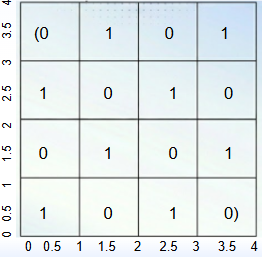

In [ ]:
  # 2. Configurar la figura
    fig, ax = plt.subplots(figsize=(6, 6))

    # Dibujar el tablero usando un mapa de colores (Blanco y Gris oscuro/Negro)
    # cmap='binary' usa blanco para 0 y negro para 1.
    ax.imshow(tablero, cmap='binary', origin='upper')

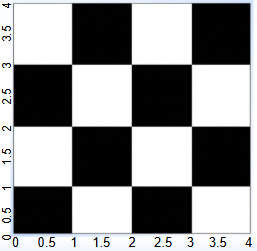

In [ ]:
    # 3. Colocar las Reinas
    # La solución es un vector donde índice=fila, valor=columna
    # Unicode de la Reina Negra: \u265B (♛)
    for fila, columna in enumerate(solucion):
        # ax.text(x, y, string) -> x es columna, y es fila
        ax.text(columna, fila, '♛', fontsize=40,
                ha='center', va='center', color='gold', # Color dorado para resaltar sobre B/N
                path_effects=[dict(linewidth=2, foreground='black')]) # Borde negro para contraste



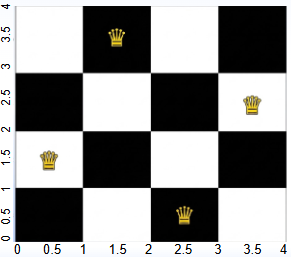

In [ ]:
    # 4. Configuración estética (Grid de distancia 1)
    # Ponemos los ticks en el medio (0, 1, 2...) para que coincidan con las casillas
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))

    # Etiquetas de los ejes (opcional, para ver coordenadas)
    ax.set_xticklabels(np.arange(n))
    ax.set_yticklabels(np.arange(n))

    # Título
    ax.set_title(f"Solución N-Reinas (N={n})\nVector: {solucion}", fontsize=14)

    # Quitar las lineas de los bordes de los ejes si se desea un look más limpio
    ax.tick_params(which='both', length=0) # Ocultar las marcas de los ticks

    plt.show()

# --- EJECUCIÓN ---

if __name__ == "__main__":
    # Ejemplo
    N = 4
    print(f"Calculando solución para {N} reinas...")

    solucion_encontrada = solve_n_queens(N)

    if solucion_encontrada:
        print(f"Solución encontrada: {solucion_encontrada}")
        dibujar_tablero(solucion_encontrada)
    else:
        print("No se encontró solución.")

(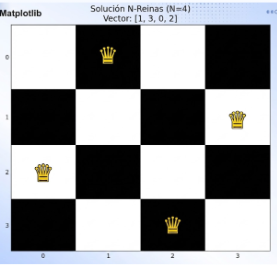)

# **05 CÓDIGO PRINCIPAL**


### 1. Importación y Configuración del Entorno

Comenzamos importando las librerías necesarias. Destacamos el uso de:
* `time`: Para medir el rendimiento en el modo comparativo.
* `SOLUCIONES_CONOCIDAS`: Un diccionario que actúa como "oráculo".

> **Nota importante sobre el límite $N=12$:**
> Hemos limitado la validación estricta de soluciones totales hasta **$N=12$** (14,200 soluciones).
> Calcular todas las soluciones para $N \ge 13$ requiere un tiempo computacional excesivo para una demostración interactiva.

In [ ]:
import time
# Asegúrate de que los módulos backtracking, min_conflicts y matplotlib1 existen
import backtracking
import min_conflicts
import matplotlib1

# Tabla recortada hasta N=12
SOLUCIONES_CONOCIDAS = {
    1: 1, 2: 0, 3: 0, 4: 2, 5: 10, 6: 4, 7: 40, 8: 92,
    9: 352, 10: 724, 11: 2680, 12: 14200
}

print("Configuración cargada correctamente.")

## Inicio de la Función Principal y Validaciones

Entramos en un bucle `while True` para permitir múltiples ejecuciones sin reiniciar el kernel.

Aquí gestionamos los **casos borde matemáticos**:
* **$N=1$:** Solución trivial (una reina en un tablero de 1x1).
* **$N=2$ y $N=3$:** Matemáticamente imposible resolverlo sin que las reinas se ataquen.
* **Validación de tipos:** Se asegura que el usuario introduzca enteros positivos.

In [ ]:
def main():
    print("=== PROGRAMA PRINCIPAL N-REINAS ===")

    while True:
        try:
            entrada = input("\nIntroduzca el tamaño del tablero (N) o 's' para salir: ")
            if entrada.lower() == 's':
                break
            N = int(entrada)
        except ValueError:
            print("Por favor, introduce un número entero válido.")
            continue

        if N <= 0:
            print("Por favor, introduce un tamaño positivo.")
            continue

        # Caso Trivial
        if N == 1:
            print("Solución trivial.")
            matplotlib1.dibujar_tablero([0], 1, 1)
            continue

        # Casos Imposibles
        if N == 2 or N == 3:
            print("La dimensión del tablero ha de ser distinta de 2 o 3 (sin solución).")
            continue

        # --- SELECCIÓN DE ALGORITMO ---
        print(f"\nOpciones para N={N}:")
        if N > 20:
            print("(!) Recomendación: Para N > 20 es más eficiente: Min-conflicts.")

        modo = input("Elige algoritmo: 'b': Backtracking, 'm': Min-conflicts o 'c': Comparativa: ").lower()
        soluciones = []

## Opción C: Comparativa de Algoritmos

Esta sección es útil para el análisis de complejidad. Ejecuta ambos métodos buscando **una sola solución** y usa `time.perf_counter()` para determinar cuál es más rápido.

* **Backtracking:** Complejidad factorial $O(N!)$. Tiende a ser lento para $N > 20$.
* **Min-Conflicts:** Algoritmo heurístico iterativo. Suele ser extremadamente rápido ($O(N)$ en la práctica) para encontrar una solución, aunque no garantiza encontrarla siempre si el límite de iteraciones es bajo.

In [ ]:
# --- OPCIÓN C: COMPARATIVA ---
        if modo == 'c':
            print(f"\n--- Comparativa de tiempos (N={N}) para 1 solución ---")

            # 1. Medir Backtracking
            start_b = time.perf_counter()
            sol_b = backtracking.soluciones_reinas(N, limite_soluciones=1)
            end_b = time.perf_counter()
            tiempo_b = end_b - start_b

            if sol_b:
                print(f"Backtracking:   {tiempo_b:.6f} segundos.")
            else:
                print(f"Backtracking:   Tiempo límite excedido o sin solución.")

            # 2. Medir Min-Conflicts
            start_m = time.perf_counter()
            iters = 1000 if N > 50 else 5000
            sol_m = min_conflicts.solve_nqueens_min_conflicts(N, max_iterations=iters)
            end_m = time.perf_counter()
            tiempo_m = end_m - start_m

            if sol_m:
                print(f"Min-Conflicts:  {tiempo_m:.6f} segundos.")
            else:
                print(f"Min-Conflicts:  No encontró solución en el límite de iteraciones.")

            if sol_b and sol_m:
                ganador = "Backtracking" if tiempo_b < tiempo_m else "Min-Conflicts"
                print(f"--> Más rápido: {ganador}")
            continue

## Opción B: Backtracking (Búsqueda Exacta)

Aquí utilizamos el diccionario `SOLUCIONES_CONOCIDAS` como un **guardián de lógica**. Si el usuario pide 5 soluciones para $N=4$ (que solo tiene 2), lanzamos un error personalizado antes de calcular, mejorando la experiencia de usuario.

Incluye un bucle interactivo para la visualización: en lugar de abrir todas las ventanas de golpe (lo cual podría colgar el sistema operativo con $N$ grandes), mostramos las soluciones una por una bajo demanda del usuario.

In [ ]:
# --- OPCIÓN B: BACKTRACKING ---
        elif modo == 'b':
            opcion_cant = input("¿Cuántas soluciones? Introduzca un número o 't' para todas: ").lower()

            limite = 1

            if opcion_cant == 't':
                limite = float('inf') # Infinito para buscar todas
                print(f"Calculando TODAS las soluciones posibles para N={N}...")
            else:
                try:
                    limite = int(opcion_cant)
                    # VALIDACIÓN DE LÍMITE (Limitada a N=12)
                    if N in SOLUCIONES_CONOCIDAS:
                        max_posible = SOLUCIONES_CONOCIDAS[N]
                        if limite > max_posible:
                            raise ValueError(f"Estás pidiendo {limite} soluciones, pero para N={N} solo existen {max_posible}.")
                    elif limite > 1000:
                         print(f"(!) Aviso: N={N} no está en la tabla de validación segura (N>12). Puede tardar.")

                except ValueError as e:
                    print(f"\n[ERROR]: {e}")
                    continue

            print(f"Ejecutando Backtracking...")
            start = time.time()
            soluciones = backtracking.soluciones_reinas(N, limite_soluciones=limite)
            end = time.time()

            cant_encontradas = len(soluciones)
            if soluciones:
                print(f"Se encontraron {cant_encontradas} solución(es) en {end - start:.4f} s.")

                # Bucle interactivo paso a paso
                for i, sol in enumerate(soluciones):
                    matplotlib1.dibujar_tablero(sol, i + 1, cant_encontradas)

                    if i < cant_encontradas - 1:
                        seguir = input("¿Mostrar siguiente solución? (s/n): ").lower()
                        if seguir != 's':
                            break
            else:
                print("No se encontraron soluciones.")

## Opción M: Min-Conflicts y Entry Point

Min-Conflicts es ideal para $N$ grandes (ej. 100, 1000). Es un algoritmo de reparación local: coloca las reinas aleatoriamente y mueve aquella que tenga más conflictos a una posición con menos conflictos.

* **Ajuste de Iteraciones:** Si $N > 100$, aumentamos el límite de iteraciones permitidas (`iters`) para darle más oportunidad al algoritmo de converger.
* **Entry Point:** Finalmente, el bloque `if __name__ == "__main__":` asegura que el código se ejecute.

In [ ]:
# --- OPCIÓN M: MIN-CONFLICTS ---
        elif modo == 'm':
            print(f"Usando Min-Conflicts para N={N}...")
            start = time.time()
            # Ajuste dinámico de iteraciones según tamaño del problema
            iters = 10000 if N > 100 else 5000
            una_solucion = min_conflicts.solve_nqueens_min_conflicts(N, max_iterations=iters)
            end = time.time()

            if una_solucion:
                print(f"¡Solución encontrada en {end - start:.4f} s!")
                matplotlib1.dibujar_tablero(una_solucion, 1, 1)
            else:
                print("No se pudo encontrar una solución dentro del límite de iteraciones.")

        else:
            print("Opción no reconocida. Inténtalo de nuevo.")

# Punto de entrada del script
if __name__ == "__main__":
    # Nota: En Jupyter, ejecutar esta celda iniciará el bucle interactivo de inputs.
    main()

# **06 APLICACIONES REALES**
# ¿POR QUÉ RESOLVER LAS N-REINAS? ¿A QUÉ ÁMBITOS LO PODEMOS EXTRAPOLAR?

Es común cuestionar la utilidad práctica de resolver un problema de ajedrez. Sin embargo, las N-Reinas representan el paradigma por excelencia de los **Problemas de Satisfacción de Restricciones (CSP)**.

### 1. Backtracking
El backtracking es un algoritmo de retroceso que se puede utilizar también para resolver rompecabezas: donde si una opción conduce a una contradicción o callejón sin salida, el algoritmo puede retroceder al elemento anterior y probar otra opción.

Sus aplicaciones prácticas incluyen:
* **Generación de combinaciones:** Sirve para generar permutaciones, optimizar recursos, o diseñar experimentos y simulaciones con resultados hipotéticos bajo ciertos escenarios.
* **Rutas y Navegación:** Se puede usar para explorar caminos y fijar nodos y rutas; donde el algoritmo retrocede para corregir puntos de trayectoria incorrectos.
A continuación se muestra el código asociado a la generación de una ruta que pasa por varios notos (una aplicación directa del backtracking):



In [ ]:
# BACKTRACKING RUTAS GPS

# Definimos un grafo de ejemplo para que el código funcione
grafo = {
    "A": ["B", "C"],
    "B": ["D", "E"],
    "C": ["F"],
    "D": [],
    "E": ["F"],
    "F": []
}

def rutas_gps(origen, destino, limite_rutas=1):
    rutas = []
    camino = []

    def backtracking(nodo_actual):
        # Si ya tenemos suficientes rutas, paramos
        if len(rutas) >= limite_rutas:
            return

        camino.append(nodo_actual)

        # Si llegamos al destino : solución encontrada
        if nodo_actual == destino:
            rutas.append(list(camino))
        else:
            # Nota: 'grafo' debe estar definido en el alcance global o pasarse como argumento
            for vecino in grafo[nodo_actual]:
                # Restricción: no visitar el mismo nodo dos veces
                if vecino not in camino:
                    backtracking(vecino)

        # Backtracking: deshacer último movimiento
        camino.pop()

    backtracking(origen)
    return rutas

# Ejecución
if __name__ == "__main__":
    # Busca caminos desde A hasta F
    print(rutas_gps("A", "F", limite_rutas=2))

### 2. Min-Conflicts

Respecto a Min-conflicts, sus usos son muy parecidos a los de los algoritmos de retroceso. Carecen de la posibilidad de analizar todos los caminos y probar todas las combinaciones posibles, pero son de gran importancia cuando tratamos con **problemas a escala masiva** (con un número de reinas grande).



Ejemplos clave:

* **Diseño de circuitos:** Donde debemos colocar millones de transistores.

* **Coloreado de mapas:** Si queremos simplemente colorear un mapa sin que compartan el mismo color los territorios fronterizos.

###

Para el correcto estudio de la eficiencia hemos realizado una recogida de datos para ver como opera el programa.Por un lado, hemos usado un contador de iteraciones que ha sido colocado de manera que cuenta las veces que recorre todas las columnas.

# **07 VISUALIZACIÓN Y CONCLUSIONES**


# Estudio de datos


### Contador de iteraciones


Para el correcto estudio de la eficiencia del algoritmo, hemos realizado una recogida de datos con el objetivo de analizar cómo opera el programa durante su ejecución. Este análisis resulta útil debido al elevado coste computacional que puede alcanzar el algoritmo a medida que aumenta el tamaño del tablero.


Por un lado, hemos utilizado un contador de iteraciones, el cual ha sido situado de manera que contabiliza el número de veces que el algoritmo recorre todas las columnas del tablero. Este contador nos permite medir de forma precisa cuántas comprobaciones realiza el programa al intentar colocar una reina en una posición válida.

In [ ]:
#--EJEMPLO CON BACKTRACKING--

def es_valido(fila, col, reinas):
    for r in range(fila):
        if col == reinas[r]:
            return False
        elif abs(col - reinas[r]) == abs(fila - r):
            return False
    return True

def soluciones_reinas(n, limite_soluciones=1):
    reinas = [-1] * n
    soluciones = []
    #Definimos un contador de iteraciones
    contador_iteraciones = 0

    def colocar_reinas(fila):
    ##Esto se usa para que la función colocar_reinas() pueda modificar la variable contador_iteraciones definida en soluciones_reinas().
        nonlocal contador_iteraciones

        if len(soluciones) >= limite_soluciones:
            return

        if fila == n:
            soluciones.append(list(reinas))
            return

        for col in range(n):
          #Sumamos 1 por cada columna que recorre
            contador_iteraciones += 1
            if es_valido(fila, col, reinas):
                reinas[fila] = col
                colocar_reinas(fila + 1)
                reinas[fila] = -1

    colocar_reinas(0)
    return soluciones, contador_iteraciones

soluciones, iteraciones = soluciones_reinas(n=8)
print(soluciones)
print(iteraciones)

# Módulo time

Para continuar con un estudio real de la eficiencia de ambos métodos, hemos usado el módulo time para calcular cuanto tarda cada uno en ejecutarse.Para ello hay que usar un contador de inicio con el comando (time.perfcounter) que establece un contador desde el principio de la función en el momento que se inicializa y luego usamos otro al final de la misma manera que acaba en el momento que da todas las soluciones requeridas. Esto se hace de esta manera ya que este módulo no toma el inicio en el instante cero,sino que toma el inicio según el reloj interno que tiene el ordenador,se resta el tiempo final menos el inicial para que nos dé el tiempo que tarda en ejecutarse.

In [ ]:
#--EJEMPLO CON BACKTRACKING--

#Importamos la librería time

import time
def es_valido(fila, col, reinas):
    for r in range(fila):
        if col == reinas[r]:
            return False
        elif abs(col - reinas[r]) == abs(fila - r):
            return False
    return True

def soluciones_reinas(n, limite_soluciones=1):
    reinas = [-1] * n
    soluciones = []



    def colocar_reinas(fila):



        if len(soluciones) >= limite_soluciones:
            return

        if fila == n:
            soluciones.append(list(reinas))
            return

        for col in range(n):

            if es_valido(fila, col, reinas):
                reinas[fila] = col
                colocar_reinas(fila + 1)
                reinas[fila] = -1

    colocar_reinas(0)
    return soluciones
    #Contador de tiempo inicial
inicio = time.perf_counter()
soluciones = soluciones_reinas(n=8)
#Contador de tiempo  final
fin = time.perf_counter()
print(soluciones)
#Imprimimos el tiempo de ejecución
print("El tiempo de ejecución es", fin-inicio)


### Representación de los datos de iteraciones y tiempo

#### Para backtracking soluciones=5


Al representar las gráficas obtenidas a partir de los datos experimentales, se observa que el algoritmo de backtracking presenta un buen rendimiento para valores pequeños.En estos casos, el tiempo de ejecución y el número de iteraciones necesarias para encontrar soluciones son relativamente bajos, lo que permite dar infinidad de soluciones en poco tiempo

Sin embargo, a medida que el número de reinas aumenta, el tiempo e iteraciones aumentan significativamente. Cuando N supera el valor de 20, el tiempo e iteraciones comienzan a crecer de manera exponencial. Este crecimiento se vuelve especialmente crítico a partir N=27, a partir del cual el programa ya no es capaz de encontrar cinco soluciones en un tiempo razonable(En nuestra propia experiencia lo dejamos cargando 10 minutos y seguía ejectándose.

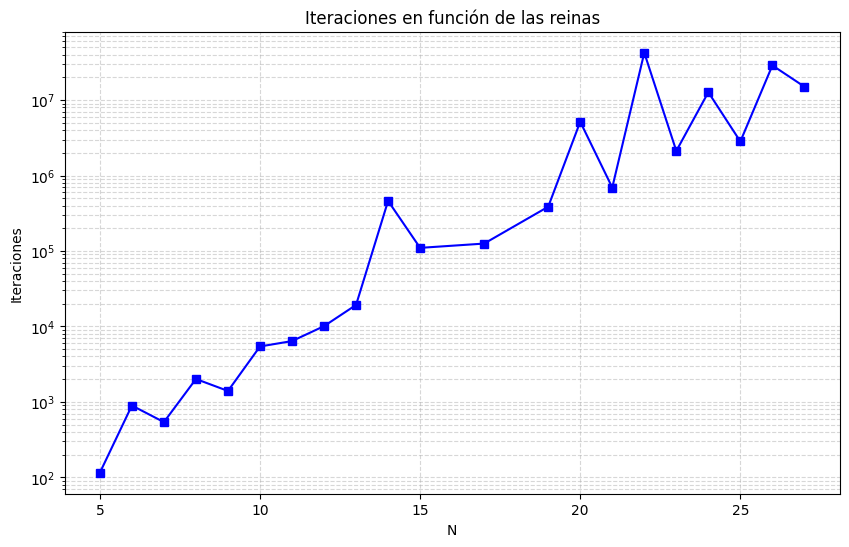

/tmp/ipython-input-2048937135.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


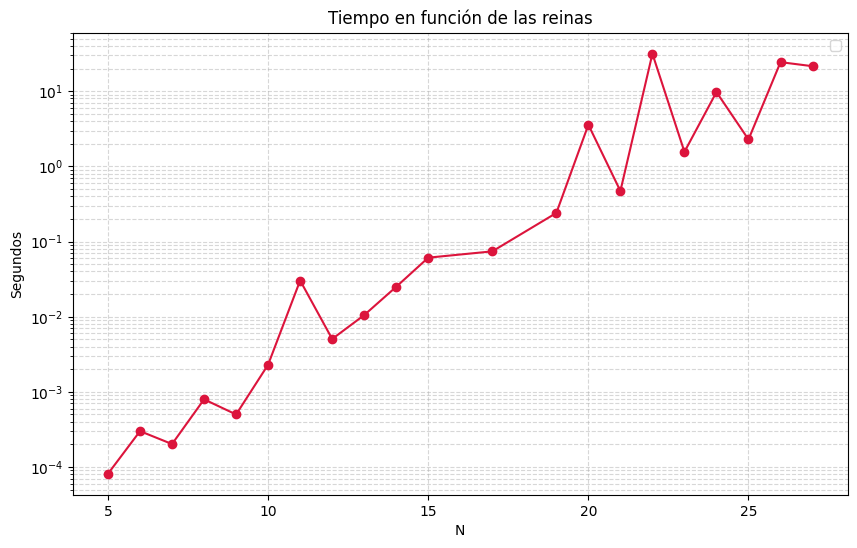

In [ ]:
import matplotlib.pyplot as plt



n = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27]

iteraciones = [
    115, 894, 539, 2008, 1395, 5420, 6391, 10080, 19253,
    460340, 109890, 125256, 385567, 5158600, 692265,
    42397564, 2115908, 12703200, 2823075, 28781818, 15038433
]




segundos = [
    8.14e-5, 0.0003, 0.000202, 0.000795, 0.0005, 0.0023, 0.0303, 0.00505, 0.0105,
    0.025, 0.061, 0.074, 0.24, 3.58, 0.47,
    31.54, 1.56, 9.74, 2.28, 24.36, 21.52
]

# GRAFICA: Iteraciones
plt.figure(figsize=(10, 6))
plt.plot(n, iteraciones, 's-', color='blue')
plt.yscale('log')
plt.title("Iteraciones en función de las reinas")
plt.xlabel("N")
plt.ylabel("Iteraciones")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


# GRAFICA: Segundos
plt.figure(figsize=(10, 6))
plt.plot(n, segundos, 'o-', color='crimson')
plt.yscale('log')
plt.title("Tiempo en función de las reinas")
plt.xlabel("N")
plt.ylabel("Segundos")
plt.grid(True, which="both", ls="--", alpha=0.5)


plt.legend()
plt.show()

### Para backtracking soluciones=1

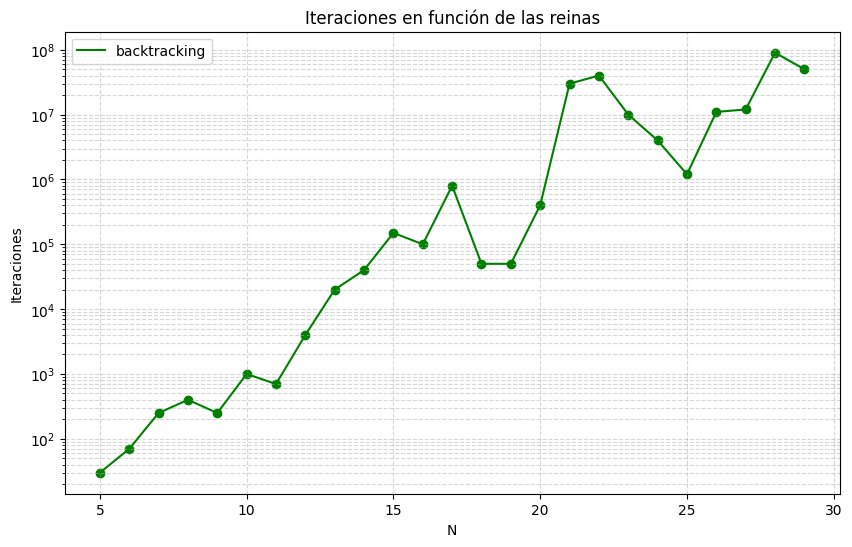

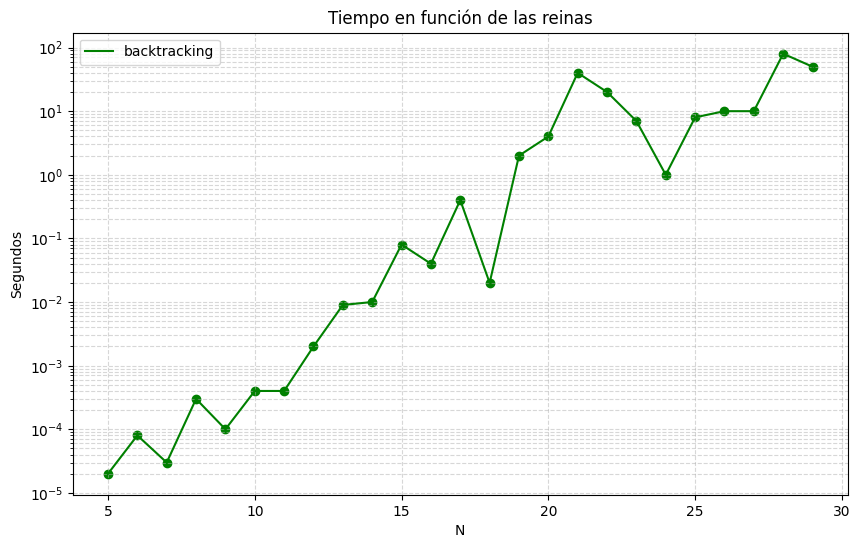

In [ ]:
N=[
   5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29
]


iteraciones1 = [
    30, 70, 250, 400, 250, 1000, 700, 4000, 20000, 40000, 150000, 100000, 800000, 50000, 50000,
    400000, 30000000, 40000000, 10000000, 4000000, 1200000, 11000000, 12000000, 90000000, 50000000
]
tiempo1 = [
    2e-5, 8e-5, 3e-5, 3e-4, 1e-4, 4e-4, 4e-4, 2e-3, 9e-3, 1e-2, 8e-2, 4e-2, 4e-1, 2e-2, 2.0,
    4.0, 40.0, 20.0, 7.0, 1.0, 8.0, 10.0, 10.0, 80.0, 50.0
]


# GRAFICA: iteraciones
plt.figure(figsize=(10, 6))
plt.plot(N, iteraciones1, color='green',label="backtracking")
plt.scatter(N, iteraciones1, color='green')
plt.yscale('log')
plt.title("Iteraciones en función de las reinas")
plt.xlabel("N")
plt.ylabel("Iteraciones")

plt.grid(True, which="both", ls="--", alpha=0.5)

plt.legend()
plt.show()


# GRAFICA: Segundos
plt.figure(figsize=(10, 6))


plt.plot(N,tiempo1, color='green',label="backtracking")
plt.scatter(N, tiempo1, color='green')
plt.yscale('log')
plt.title("Tiempo en función de las reinas")
plt.xlabel("N")
plt.ylabel("Segundos")
plt.grid(True, which="both", ls="--", alpha=0.5)


plt.legend()
plt.show()

## Minconflicts


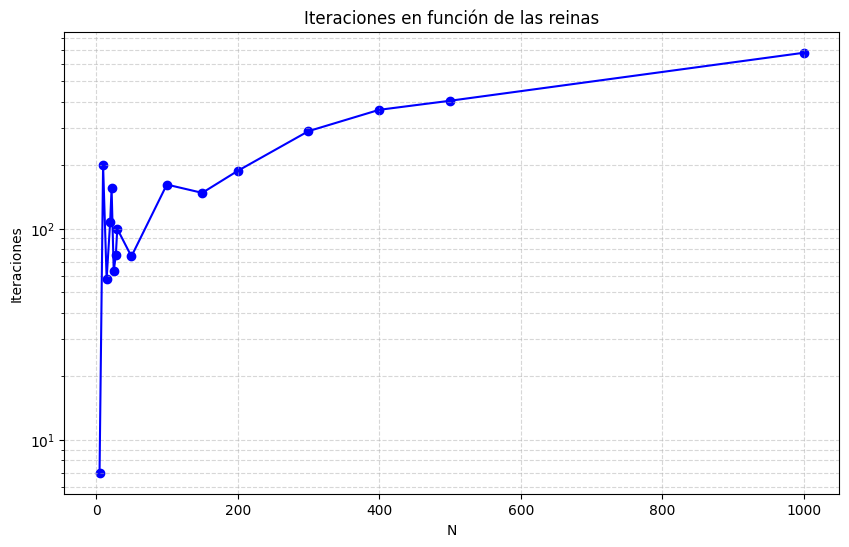

/tmp/ipython-input-391103916.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


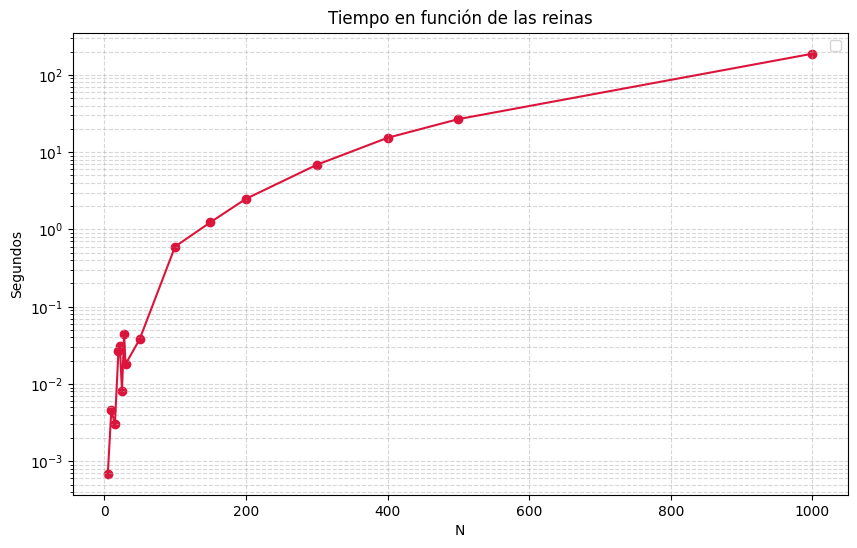

In [ ]:
import matplotlib.pyplot as plt

n=[5,10,15,20,22,25,28,30,50,100,150,200,300,400,500,1000]
segundos=[0.00069,0.0046,0.003,0.0267,0.0312,0.0081,0.0447,0.018,0.038,0.6,1.24,2.49,6.86,15.34,26.78,188]
iteraciones=[7,200,58,108,156,63,75,100,74,162,148,188,290,366,404,682]
# GRAFICA 2: iteraciones
plt.figure(figsize=(10, 6))
plt.plot(n, iteraciones, color='blue')
plt.scatter(n, iteraciones, color='blue')
plt.yscale('log')
plt.title("Iteraciones en función de las reinas")
plt.xlabel("N")
plt.ylabel("Iteraciones")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# GRAFICA 2: Segundos
plt.figure(figsize=(10, 6))
plt.plot(n, segundos, color='crimson')
plt.scatter(n,segundos, color="crimson")
plt.yscale('log')
plt.title("Tiempo en función de las reinas")
plt.xlabel("N")
plt.ylabel("Segundos")
plt.grid(True, which="both", ls="--", alpha=0.5)


plt.legend()
plt.show()


Sin embargo, con el algoritmo de  Min-conflicts se produce algo contraintuitivo. Al principio se disparan las combinaciones porque en los tableros pequeños las restricciones son muy fuertes y el algoritmo “tropieza mucho”. Pero luego en tableros gigantes hay tanto espacio libre que arreglar los conflictos es trivial y rápido.

#### BACKTRACKING VS MIN-CONFLICTS

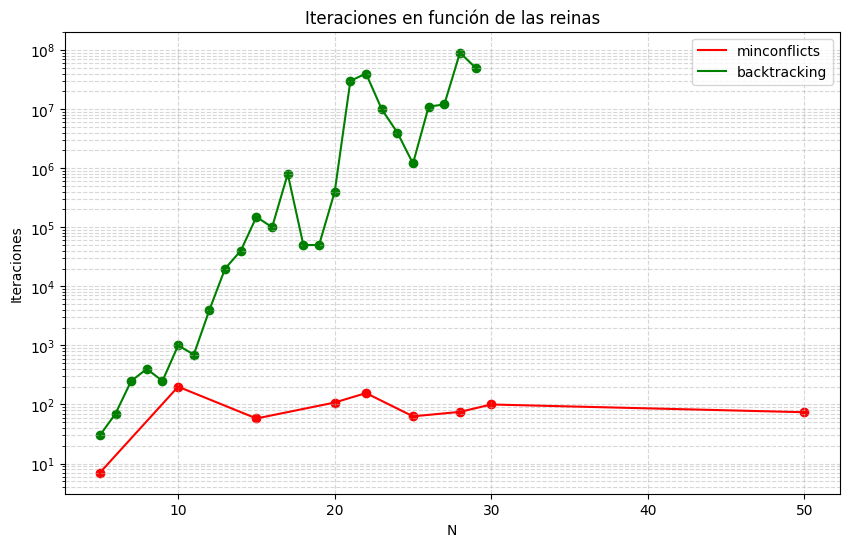

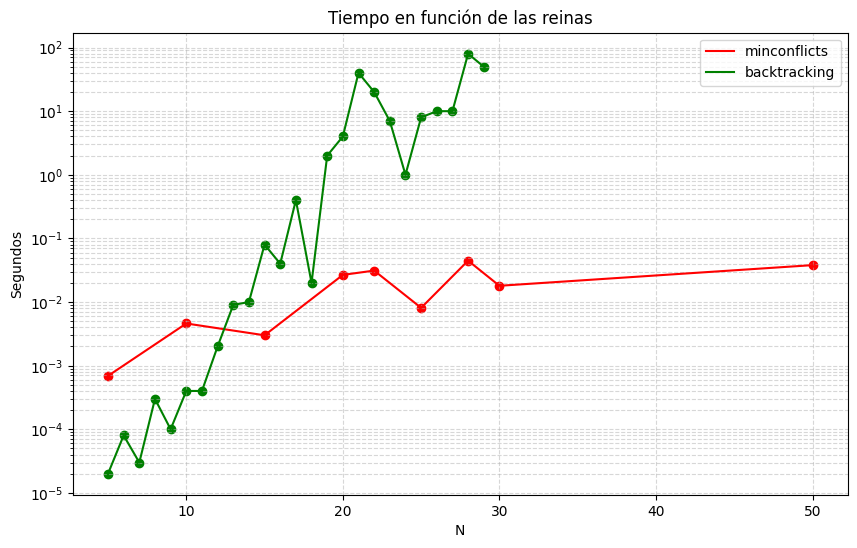

In [ ]:
N=[
   5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29
]


iteraciones1 = [
    30, 70, 250, 400, 250, 1000, 700, 4000, 20000, 40000, 150000, 100000, 800000, 50000, 50000,
    400000, 30000000, 40000000, 10000000, 4000000, 1200000, 11000000, 12000000, 90000000, 50000000
]
tiempo1 = [
    2e-5, 8e-5, 3e-5, 3e-4, 1e-4, 4e-4, 4e-4, 2e-3, 9e-3, 1e-2, 8e-2, 4e-2, 4e-1, 2e-2, 2.0,
    4.0, 40.0, 20.0, 7.0, 1.0, 8.0, 10.0, 10.0, 80.0, 50.0
]

n=[5,10,15,20,22,25,28,30,50]
segundos=[0.00069,0.0046,0.003,0.0267,0.0312,0.0081,0.0447,0.018,0.038,]
iteraciones=[7,200,58,108,156,63,75,100,74]
# GRAFICA: iteraciones
plt.figure(figsize=(10, 6))
plt.plot(n, iteraciones, color='red',label="minconflicts")
plt.scatter(n, iteraciones, color='red')
plt.plot(N, iteraciones1, color='green',label="backtracking")
plt.scatter(N, iteraciones1, color='green')
plt.yscale('log')
plt.title("Iteraciones en función de las reinas")
plt.xlabel("N")
plt.ylabel("Iteraciones")

plt.grid(True, which="both", ls="--", alpha=0.5)

plt.legend()
plt.show()


# GRAFICA: Segundos
plt.figure(figsize=(10, 6))
plt.plot(n, segundos, color='red',label="minconflicts")
plt.scatter(n,segundos, color='red')
plt.plot(N,tiempo1, color='green',label="backtracking")
plt.scatter(N, tiempo1, color='green')
plt.yscale('log')
plt.title("Tiempo en función de las reinas")
plt.xlabel("N")
plt.ylabel("Segundos")
plt.grid(True, which="both", ls="--", alpha=0.5)


plt.legend()
plt.show()

Por último, si se solapan las dos gráficas; se observa una divergencia extrema entre ambos métodos. El backtracking colapsa cerca de N = 20, disparándose a millones de iteraciones y es computacionalmente costoso, por lo que sería un buen criterio utilizar Min–Conflicts a partir de este tamaño.


# **08 WEBGRAFÍA**


### Backtracking

-https://es.wikipedia.org/wiki/B%C3%BAsqueda_de_fuerza_bruta


-https://www.youtube.com/watch?v=YwRjEOFxvO0

-https://www.youtube.com/watch?v=ip2jC_kXGtg

-https://www.youtube.com/watch?v=KjEmT74Z1wk

-https://www.geeksforgeeks.org/dsa/n-queen-problem-backtracking-3/


### Min-conflicts

https://en.wikipedia.org/wiki/Min-conflicts_algorithm

https://medium.com/@amarjaiswal870/solving-the-8-queens-problem-with-min-conflicts-algorithm-c113cc01579b

### Matplotlib

-https://matplotlib.org/stable/index.html

-https://matplotlib.org/

### Módulo Time


-https://docs.python.org/es/3.10/library/time.html#time.perf_counter
